In [3]:
%cd ~/work/dev/Others/yerko/other/csc

/home/jovyan/work/dev/Others/yerko/other/csc


In [42]:
import pandas as pd
from pathlib import Path
import lightgbm as lgb
from pymongo import MongoClient
import matplotlib.pyplot as plt

from creds import MONGO_SERVER_URL

## Load data

In [43]:
VERSION = "v2.9_sm_features"


mc = MongoClient(MONGO_SERVER_URL)
featurestore = mc.csc.featurestore

base_fields = [
    "_id",
    # "image_url1",
    # "image_url2",
    "ID",
    "is_same",
]

features_v2 = [
    # "left_grayscale",
    # "right_grayscale",
    # "unpadded.ahash_16",
    "unpadded.ahash_4",
    # "unpadded.ahash_8",
    "unpadded.colorhash_21",
    # "unpadded.colorhash_63",
    # "unpadded.dhash_16",
    "unpadded.dhash_4",
    # "unpadded.dhash_8",
    # "unpadded.dhash_verical_16",
    # "unpadded.height_diff",
    # "unpadded.height_ratio",
    # "unpadded.left_height",
    # "unpadded.left_width",
    # "unpadded.phash_16_8",
    "unpadded.phash_4",
    # "unpadded.phash_8",
    # "unpadded.right_height",
    # "unpadded.right_width",
    # "unpadded.sift_similarity",
    "unpadded.orb_similarity",
    # "unpadded.whash_16_db4",
    # "unpadded.whash_16_haar",
    "unpadded.whash_4_haar",
    # "unpadded.whash_8_haar",
    # "unpadded.width_diff",
    # "unpadded.width_ratio",
]

df = pd.json_normalize(featurestore.find({"is_test": False}, base_fields + features_v2))
df_test = pd.json_normalize(featurestore.find({"is_test": True}, base_fields + features_v2))


## Tune num_round

c:\Users\Andrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 23162, number of negative: 49348
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 72510, number of used features: 6
[LightGBM] [Info] Number of positive: 23162, number of negative: 49348
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 72510, number of used features: 6
[LightGBM] [Info] Number of positive: 23162, number of negative: 49348
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of te

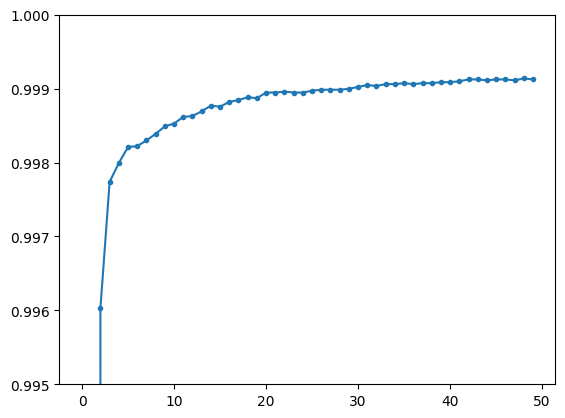

In [44]:
# use it to find best num round
from sklearn.metrics import f1_score
import numpy as np

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat, average="macro"), True

param = {
    # "max_depth": 5,
    "n_jobs": 32,
    "num_round": 50,
    'metric': [],
    'objective': 'binary'
}

train_lgbm = lgb.Dataset(df.drop(["is_same", "_id"], axis=1), 
                         label=df["is_same"])
clf = lgb.cv(param, train_lgbm, feval=lgb_f1_score, seed=42, nfold=5, return_cvbooster=True)

plt.plot(clf['f1-mean'], marker=".")
plt.ylim(0.995, 1)

print(np.argmax(clf['f1-mean']), np.max(clf['f1-mean']))

## Collect metrics

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, classification_report, roc_auc_score


param = {
    # "max_depth": 5,
    "n_jobs": 32,
    "num_iterations": 43,
    'metric': [],
    'objective': 'binary'
}

X = df.drop(["is_same", "_id"], axis=1)
y = df["is_same"]

clf = LGBMClassifier(**param)
results = cross_validate(clf, X, y, cv=5, scoring="f1_macro", return_estimator=True, return_indices=True)

y_pred = np.zeros_like(y)
test_pred_oof = []
for model, idx in zip(results["estimator"], results["indices"]["test"]):
    y_pred[idx] = model.predict_proba(X.iloc[idx])[:, 1]
    test_pred_oof.append(model.predict_proba(df_test.drop(["_id", "ID"], axis=1))[:, 1])
test_pred_oof = np.mean(test_pred_oof, axis=0)

scores = results["test_score"]
print("Train:", scores.mean(), scores.std())

thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y, y_pred > threshold, average="macro") for threshold in thresholds]

i = np.argmax(scores)
best_threshold = thresholds[i]
score = scores[i]
print("Best threshold:", best_threshold, score)

print(classification_report(y, y_pred > best_threshold, digits=6))

print(f"{roc_auc_score(y, y_pred)=}")

c:\Users\Andrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Andrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Andrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Andrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it in

Train: 0.9990608917639111 0.0001354167533156331
Best threshold: 0.4 0.9990736827384386
              precision    recall  f1-score   support

         0.0   0.999287  0.999530  0.999408     61685
         1.0   0.998998  0.998480  0.998739     28953

    accuracy                       0.999195     90638
   macro avg   0.999142  0.999005  0.999074     90638
weighted avg   0.999195  0.999195  0.999195     90638

roc_auc_score(y, y_pred)=0.999798924201687


## Predict & Save

In [38]:
def get_submission(ids, predicts, thresold=0.5):
    submission = pd.DataFrame({
        "ID": ids,
        "is_same": predicts
    })

    submission["is_same"] = submission["is_same"].astype(int)
    submission["same"] = (submission["is_same"] == 1).astype(int)
    submission["different"] = (submission["is_same"] == 0).astype(int)
    submission.drop(columns=["is_same"], inplace=True)
    return submission

In [39]:
df["predict"] = y_pred
df["predict_label"] = (df["predict"] > best_threshold).astype(int)
df.to_csv(f"lgbm_{VERSION}_validation.csv", index=False)

In [40]:
submission = get_submission(df_test["ID"], test_pred_oof > best_threshold)
submission.to_csv(f"lgbm_{VERSION}_submission_oof.csv", index=False)

In [41]:
model = clf.fit(X, y)
test_pred = model.predict_proba(df_test.drop(["_id", "ID"], axis=1))[:, 1]

submission = get_submission(df_test["ID"], test_pred > best_threshold)
submission.to_csv(f"lgbm_{VERSION}_submission.csv", index=False)

c:\Users\Andrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

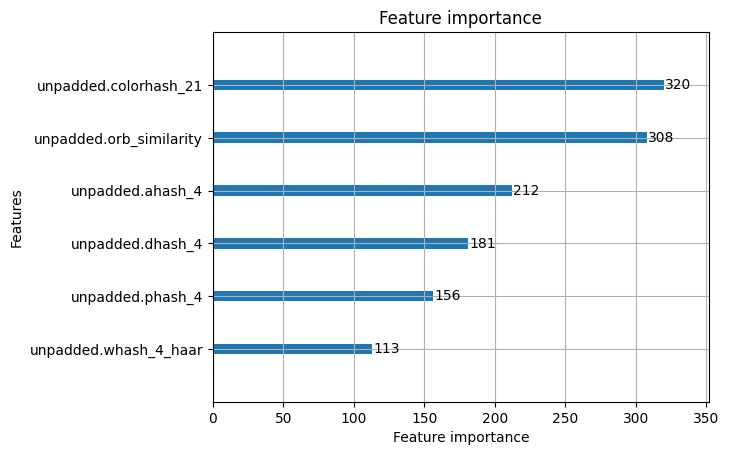

In [46]:
lgb.plot_importance(model)